In [9]:
import pandas as pd
import numpy as np
import sklearn.model_selection as sk_ms
import warnings
warnings.filterwarnings('ignore')

# data visualization
import matplotlib
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import median

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.manifold import TSNE
from sklearn import preprocessing

from collections import Counter

import string
import re
from nltk.corpus import stopwords

import scipy
from scipy.sparse import hstack


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV 

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform


# from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression

In [3]:
pd.set_option('display.max_columns', None)

In [ ]:
# df = pd.read_csv('glassdoor_reviews.csv')

# import nltk
# from nltk.stem import PorterStemmer

# stemmer = PorterStemmer()

# def text_processor(raw):
#     if pd.isna(raw):
#         return ''
#     processed = [stemmer.stem(token) for token in word_tokenize(raw.lower())
#         if token not in STOPWORDS and token.isalnum()]
#     return ' '.join(processed)

# df_reduced = df[['overall_rating','headline','pros','cons','firm','location']]

# df_reduced['headline_processed'] = df_reduced['headline'].apply(lambda x: text_processor(x))
# df_reduced['pros_processed'] = df_reduced['pros'].apply(lambda x: text_processor(x))
# df_reduced['cons_processed'] = df_reduced['cons'].apply(lambda x: text_processor(x))
# df_reduced.head()

# df_reduced.to_csv('df_reduced.csv')

# Data

In [4]:
df = pd.read_csv('df_reduced.csv', index_col=0)
df.head()

,overall_rating,headline,pros,cons,firm,headline_processed,pros_processed,cons_processed,job_title,location
0,2,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",AFH-Wealth-Management,young colleagu poor micro manag,friendli welcom new staff easi go ethic,poor salari poor train commun,,NaN
1,2,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,AFH-Wealth-Management,excel staff poor salari,friendli help colleagu,poor salari improv progress incent work harder...,Office Administrator,"Bromsgrove, England, England"
2,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",AFH-Wealth-Management,low salari bad micromanag,easi job experi financ,low salari poor work condit littl train provid...,Office Administrator,"Bromsgrove, England, England"
3,5,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,AFH-Wealth-Management,promis deliv,nice staff work,career progress salari poor,,NaN
4,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",AFH-Wealth-Management,client report admin,easi job nice colleagu,abysm pay minimum wage actual train job role i...,Office Administrator,"Bromsgrove, England, England"


Replace NA in text with space

In [5]:
text_cols = df.select_dtypes(include='object').columns
print(text_cols)

for col in text_cols:
    df[col] = df[col].fillna('')

Index(['headline', 'pros', 'cons', 'firm', 'headline_processed',
       'pros_processed', 'cons_processed', 'job_title', 'location'],
      dtype='object')


Aggregate the overall_rating into 3 groups

In [6]:
def define_level(rating):
    if rating >= 4:
        return 'high'
    if rating <= 2:
        return 'low'
    return 'middle'

df['rating_level'] = df['overall_rating'].apply(lambda x: define_level(x))
df.head()

,overall_rating,headline,pros,cons,firm,headline_processed,pros_processed,cons_processed,job_title,location,rating_level
0,2,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",AFH-Wealth-Management,young colleagu poor micro manag,friendli welcom new staff easi go ethic,poor salari poor train commun,,,low
1,2,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,AFH-Wealth-Management,excel staff poor salari,friendli help colleagu,poor salari improv progress incent work harder...,Office Administrator,"Bromsgrove, England, England",low
2,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",AFH-Wealth-Management,low salari bad micromanag,easi job experi financ,low salari poor work condit littl train provid...,Office Administrator,"Bromsgrove, England, England",low
3,5,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,AFH-Wealth-Management,promis deliv,nice staff work,career progress salari poor,,,high
4,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",AFH-Wealth-Management,client report admin,easi job nice colleagu,abysm pay minimum wage actual train job role i...,Office Administrator,"Bromsgrove, England, England",low


In [7]:
df['rating_level'].value_counts()

high      489711
middle    185397
low       128513
Name: rating_level, dtype: int64

# Machine Learning

## Train Test Split

In [92]:
train_df, test_df = sk_ms.train_test_split(df, train_size = 0.8, random_state = 100)

In [93]:
train_df.shape

(642896, 11)

## Downsampling

In [94]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train_df[train_df.rating_level == 'high']
df_minority_low = train_df[train_df.rating_level == 'low']
df_minority_middle = train_df[train_df.rating_level == 'middle']

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,     # sample without replacement
                                   n_samples=len(df_minority_low),    # to match minority class size
                                   random_state=42)   # reproducible results

# Combine minority class with downsampled majority class
train_df_downsampled = pd.concat([df_majority_downsampled, df_minority_low, df_minority_middle])

1. TF-IDF vectorizer based machine learning model: headline, pros and cons.
2. Separate the vectorizer (#: 3 times)
Dashboard
3. top frequent phrases by company (bar chart)
4. top frequent phrases in the pros / cons by company / location / roles (bar chart)
5. Sentiment score by company / location / roles
6. Wordclouds by company / location / roles 

## TF-IDF

- Term Frequency: tf(t,d) = count of t in d / number of words in d
- Document Frequency: df(t) = occurrence of t in documents
- N(t) = Number of documents containing the term t
- Inverse Document Frequency: idf(t) = log(N/ df(t)) = log(N/N(t))
- tf-idf(t, d) = tf(t, d) * idf(t)

In [8]:
!pip install scikit-learn

     ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
     --- ------------------------------------ 0.8/8.4 MB 16.9 MB/s eta 0:00:01
     ------- -------------------------------- 1.7/8.4 MB 17.8 MB/s eta 0:00:01
     ------------ --------------------------- 2.7/8.4 MB 21.6 MB/s eta 0:00:01
     ------------------- -------------------- 4.1/8.4 MB 23.8 MB/s eta 0:00:01
     -------------------------- ------------- 5.6/8.4 MB 25.6 MB/s eta 0:00:01
     ----------------------------------- ---- 7.4/8.4 MB 27.8 MB/s eta 0:00:01
     ---------------------------------------  8.4/8.4 MB 28.2 MB/s eta 0:00:01
     ---------------------------------------- 8.4/8.4 MB 24.4 MB/s eta 0:00:00


In [10]:
train = pd.read_csv('UI_data.csv', index_col = 0)
train

,firm,job_title,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,rating_level,combined_text
0,AFH-Wealth-Management,NaN,NaN,2,4.0,3.0,NaN,2.0,3.0,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",low,"Young colleagues, poor micro managementVery fr..."
1,AFH-Wealth-Management,Office Administrator,"Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,low,"Excellent staff, poor salaryFriendly, helpful ..."
2,AFH-Wealth-Management,Office Administrator,"Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",low,"Low salary, bad micromanagementEasy to get the..."
3,AFH-Wealth-Management,NaN,NaN,5,2.0,3.0,NaN,2.0,2.0,3.0,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,high,Over promised under deliveredNice staff to wor...
4,AFH-Wealth-Management,Office Administrator,"Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",low,"client reporting adminEasy to get the job, Nic..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838561,the-LEGO-Group,Marketing Manager,"München, Bavaria, Bavaria",5,4.0,5.0,4.0,4.0,4.0,4.0,v,v,v,Just an awesome company to work for!!!,"Great company values, awesome product, smart c...",Not very easy to transfer to other locations,high,Just an awesome company to work for!!!Great co...
838562,the-LEGO-Group,Sales Associate,"London, England, England",3,NaN,NaN,NaN,NaN,NaN,NaN,o,o,o,working at lego,staff discount is really nice,micro managing is a hassle\r\ncan become menta...,middle,working at legostaff discount is really nicemi...
838563,the-LEGO-Group,Strategist,NaN,4,5.0,5.0,5.0,3.0,5.0,3.0,v,o,o,not interested in growing their people,loved brand for a lot of people,you can spend 6-10 years without any promotion...,high,not interested in growing their peopleloved br...
838564,the-LEGO-Group,Customer Service Representative,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,o,o,o,Great Place to Work,"Good wages, good hours, lots of resources","Working every other weekend, busy seasons can ...",high,"Great Place to WorkGood wages, good hours, lot..."


In [106]:
def classification(original_text=True, combine_text=True, down_sampling=True):
    
    print('Based on original headline, pros, cons\n') if original_text else print('Based on processed headline, pros, cons\n')
    print('Combine them into one corpus\n') if combine_text else print('Don\'t combine them into one corpus\n')
    print('With down-sampling') if down_sampling else print('Without down-sampling')
    
    # define your target column
    target_column = 'rating_level'
    
    # define your feature columns
    if original_text:
        text_columns = ['headline', 'pros', 'cons']
    else:
        text_columns = ['headline_processed', 'pros_processed', 'cons_processed']
        
    if down_sampling:
        train = train_df_downsampled
    else:
        train = train_df
        
    if combine_text:
        
        # create a TfidfVectorizer object
        tfidf_vectorizer = TfidfVectorizer()

        # fit the TfidfVectorizer object to the text data
        tfidf_vectorizer.fit(train[text_columns].apply(lambda x: ''.join(x), axis=1).values)

        # transform the text data into TF-IDF features
        train_features = tfidf_vectorizer.transform(train[text_columns].apply(lambda x: ''.join(x), axis=1).values)
        test_features = tfidf_vectorizer.transform(test_df[text_columns].apply(lambda x: ''.join(x), axis=1).values)
        
        # Create training data and fit the model to it
        X = train_features
        y = train[target_column]

        logreg = LogisticRegression(penalty='none') 
        logreg.fit(X, y)

        # Predict on test data
        X_test = test_features
        y_test = test_df[target_column]
        y_pred = logreg.predict(X_test)
        
    else:
        
        train_features_lst = []
        test_features_lst = []

        for i in text_columns:

            # create a TfidfVectorizer object
            tfidf_vectorizer = TfidfVectorizer()

            # fit the TfidfVectorizer object to the text data
            tfidf_vectorizer.fit(train[i].values)

            # transform the text data into TF-IDF features
            train_features = tfidf_vectorizer.transform(train[i].values)
            test_features = tfidf_vectorizer.transform(test_df[i].values)

            train_features_lst.append(train_features)
            test_features_lst.append(test_features)
            
        # Create training data and fit the model to it
        X = hstack(train_features_lst)
        y = train[target_column]

        logreg = LogisticRegression(penalty='none') 
        logreg.fit(X, y)

        # Predict on test data
        X_test = hstack(test_features_lst)
        y_test = test_df[target_column]
        y_pred = logreg.predict(X_test)
    
    # Evaluate accuracy
    df_confusion = pd.crosstab(y_test, y_pred)
    df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    display(df_confusion)
    
    # Print classification report
    print(classification_report(y_test, y_pred))    

In [107]:
for a in [True, False]:
    for b in [True, False]:
        for c in [True, False]:
            classification(original_text=a, combine_text=b, down_sampling=c)

Based on original headline, pros, cons

Combine them into one corpus

With down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,58492,4142,35365,97999
low,1279,15860,8419,25558
middle,7158,6414,23596,37168
All,66929,26416,67380,160725


              precision    recall  f1-score   support

        high       0.87      0.60      0.71     97999
         low       0.60      0.62      0.61     25558
      middle       0.35      0.63      0.45     37168

    accuracy                           0.61    160725
   macro avg       0.61      0.62      0.59    160725
weighted avg       0.71      0.61      0.63    160725

Based on original headline, pros, cons

Combine them into one corpus

Without down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,87754,2419,7826,97999
low,5548,15126,4884,25558
middle,20992,5599,10577,37168
All,114294,23144,23287,160725


              precision    recall  f1-score   support

        high       0.77      0.90      0.83     97999
         low       0.65      0.59      0.62     25558
      middle       0.45      0.28      0.35     37168

    accuracy                           0.71    160725
   macro avg       0.63      0.59      0.60    160725
weighted avg       0.68      0.71      0.68    160725

Based on original headline, pros, cons

Don't combine them into one corpus

With down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,62906,2451,32642,97999
low,899,16283,8376,25558
middle,6478,5800,24890,37168
All,70283,24534,65908,160725


              precision    recall  f1-score   support

        high       0.90      0.64      0.75     97999
         low       0.66      0.64      0.65     25558
      middle       0.38      0.67      0.48     37168

    accuracy                           0.65    160725
   macro avg       0.65      0.65      0.63    160725
weighted avg       0.74      0.65      0.67    160725

Based on original headline, pros, cons

Don't combine them into one corpus

Without down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,88870,1614,7515,97999
low,3841,16248,5469,25558
middle,18889,5315,12964,37168
All,111600,23177,25948,160725


              precision    recall  f1-score   support

        high       0.80      0.91      0.85     97999
         low       0.70      0.64      0.67     25558
      middle       0.50      0.35      0.41     37168

    accuracy                           0.73    160725
   macro avg       0.67      0.63      0.64    160725
weighted avg       0.71      0.73      0.72    160725

Based on processed headline, pros, cons

Combine them into one corpus

With down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,56745,4913,36341,97999
low,1868,14880,8810,25558
middle,8065,6399,22704,37168
All,66678,26192,67855,160725


              precision    recall  f1-score   support

        high       0.85      0.58      0.69     97999
         low       0.57      0.58      0.58     25558
      middle       0.33      0.61      0.43     37168

    accuracy                           0.59    160725
   macro avg       0.58      0.59      0.57    160725
weighted avg       0.69      0.59      0.61    160725

Based on processed headline, pros, cons

Combine them into one corpus

Without down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,87664,3014,7321,97999
low,7313,13807,4438,25558
middle,22755,5376,9037,37168
All,117732,22197,20796,160725


              precision    recall  f1-score   support

        high       0.74      0.89      0.81     97999
         low       0.62      0.54      0.58     25558
      middle       0.43      0.24      0.31     37168

    accuracy                           0.69    160725
   macro avg       0.60      0.56      0.57    160725
weighted avg       0.65      0.69      0.66    160725

Based on processed headline, pros, cons

Don't combine them into one corpus

With down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,62260,2999,32740,97999
low,1208,15907,8443,25558
middle,7032,6013,24123,37168
All,70500,24919,65306,160725


              precision    recall  f1-score   support

        high       0.88      0.64      0.74     97999
         low       0.64      0.62      0.63     25558
      middle       0.37      0.65      0.47     37168

    accuracy                           0.64    160725
   macro avg       0.63      0.64      0.61    160725
weighted avg       0.73      0.64      0.66    160725

Based on processed headline, pros, cons

Don't combine them into one corpus

Without down-sampling


Predicted,high,low,middle,All
Actual,,,,
high,89027,1727,7245,97999
low,4951,15161,5446,25558
middle,20222,4998,11948,37168
All,114200,21886,24639,160725


              precision    recall  f1-score   support

        high       0.78      0.91      0.84     97999
         low       0.69      0.59      0.64     25558
      middle       0.48      0.32      0.39     37168

    accuracy                           0.72    160725
   macro avg       0.65      0.61      0.62    160725
weighted avg       0.70      0.72      0.70    160725



#### Save Model

In [91]:
%%writefile text2rate_model.py

from joblib import dump
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import hstack

train = pd.read_csv('UI_data.csv', index_col = 0)
train.dropna(inplace=True)
train.fillna('', inplace=True)

# define your target column
target_column = 'rating_level'
# define your feature columns
text_columns = ['headline', 'pros', 'cons']

train_features_lst = []


for i in text_columns:

    # create a TfidfVectorizer object
    tfidf_vectorizer = TfidfVectorizer()

    # fit the TfidfVectorizer object to the text data
    tfidf_vectorizer.fit(train[i].values)
    
    # Save the TfidfVectorizer to a file
    dump(tfidf_vectorizer, 'C:/Users/lenovo/Documents/KaggleX/'+i+'_vectorizer.joblib')

    # transform the text data into TF-IDF features
    train_features = tfidf_vectorizer.transform(train[i].values)
    
    train_features_lst.append(train_features)

# Create training data and fit the model to it
X = hstack(train_features_lst)
y = train[target_column]

logreg = LogisticRegression(penalty=None, max_iter=1000) 
logreg.fit(X, y)

# Save the model to a file
dump(logreg, 'C:/Users/lenovo/Documents/KaggleX/logreg_model.joblib')

!python text2rate_model.py

# Text Analysis

## Top Frequent Phrases & Word Cloud

In [20]:
# !pip install spacy

In [66]:
import spacy
from spacy.lang.en import English
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.parsing.preprocessing import STOPWORDS

nlp = spacy.load("en_core_web_sm")

def get_top_noun_phrases():
    
    # Get user input
    company_input = input("Enter company name: ")
    role_input = input("Enter role name: ")
    location_input = input("Enter location: ")
    scope_input = input("Enter pros/cons/headline: ")
    
    filtered_df = df.copy()
    
    if scope_input:
        
        scope_match = process.extractOne(scope_input, ['pros','cons','headline'], scorer=fuzz.token_sort_ratio)  
        if fuzz.token_set_ratio(scope_match[0], scope_input) >= 70:      
            scope = scope_match[0]
            print("Matched scope: ", scope_match[0])
        else:
            print("pros/cons/headline not matched")
            text_columns = ['headline', 'pros', 'cons']
            filtered_df['combined_text'] = filtered_df[text_columns].apply(lambda x: ''.join(x), axis=1)
            scope = 'combined_text'
            
    else:
        text_columns = ['headline', 'pros', 'cons']
        filtered_df['combined_text'] = filtered_df[text_columns].apply(lambda x: ''.join(x), axis=1)
        scope = 'combined_text'
        
        
    if company_input:
        
        # Fuzzy match company and role
        companies = df['firm'].unique()       
        company_match = process.extractOne(company_input, companies, scorer=fuzz.token_sort_ratio)        
        if fuzz.token_set_ratio(company_match[0], company_input) >= 70:      
            print("Matched company: ", company_match[0])
            # Filter the dataframe based on the inputs
            filtered_df = filtered_df[filtered_df['firm'] == company_match[0]]
        else:
            print("No matched company")
            
    if role_input:
    
        # Fuzzy match company and role
        roles = df['job_title'].unique()
        role_match = process.extractOne(role_input, roles, scorer=fuzz.token_sort_ratio)        
        if fuzz.token_set_ratio(role_match[0], role_input) >= 70:
            print("Matched role: ", role_match[0])
            filtered_df = filtered_df[filtered_df['job_title'] == role_match[0]]           
        else:
            print("No matched role")
            
    if location_input:
        
        # Fuzzy match company and role
        locations = df['location'].unique()
        location_match = process.extractOne(location_input, locations, scorer=fuzz.token_sort_ratio)      
        if fuzz.token_set_ratio(location_match[0], location_input) >= 70:
            print("Matched location: ", location_match[0])
            filtered_df = filtered_df[filtered_df['location'] == location_match[0]]            
        else:
            print("No matched location")

    if len(filtered_df) == 0:
        print("No comments found for the specified inputs.")
        return
    
    filtered_df['text'] = filtered_df[scope].apply(lambda x: nlp(x.lower()))
    
    # Extract noun phrases
    noun_phrases = []
    for doc in nlp.pipe(filtered_df['text']):
        for chunk in doc.noun_chunks:
            if chunk.text not in STOPWORDS:
                noun_phrases.append(chunk.text)
    
    # Count the frequency of each noun phrase
    freq = pd.Series(noun_phrases).value_counts().head(15)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    freq.plot(kind='bar')
    plt.title("Top 15 frequent noun phrases in {}".format(scope))
    plt.xlabel("Noun Phrase")
    plt.ylabel("Frequency")
    plt.show()
    
    text = ' '.join(filtered_df[scope]).lower()
    
    # Generate a WordCloud object with the text and set the parameters
    wordcloud = WordCloud(stopwords=STOPWORDS,width=800, height=800, background_color='white', max_words=100, colormap='magma').generate(text)

    # Display the WordCloud using matplotlib
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


Enter company name: apple
Enter role name: analysy
Enter location: 
Enter pros/cons/headline: 
Matched company:  Apple
Matched role:   Analyst


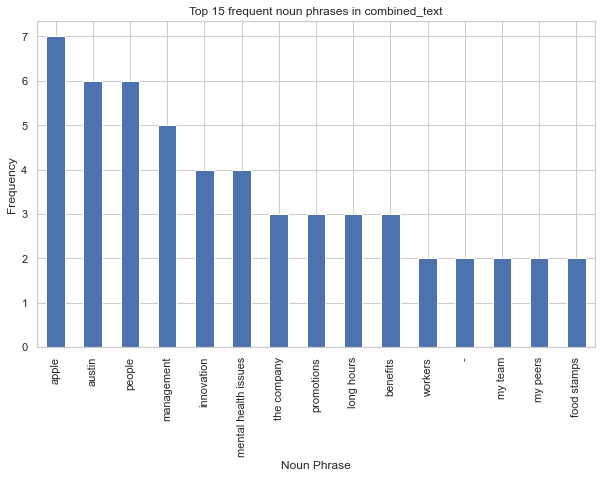

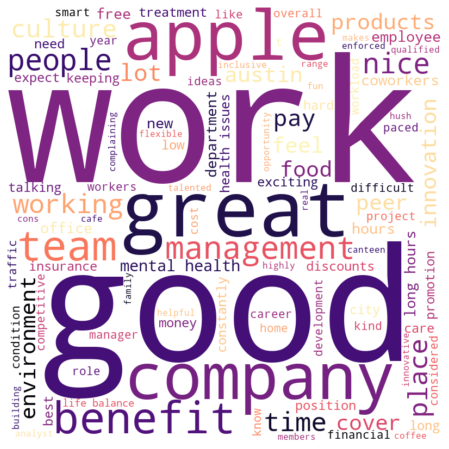

In [67]:
get_top_noun_phrases()

## Sentiment Score

In [7]:
df.shape

(838566, 8)

In [115]:
# !pip install fuzzywuzzy


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from textblob import TextBlob

def sentiment_producer():
    
    # Get user input
    company_input = input("Enter company name: ")
    role_input = input("Enter role name: ")
    location_input = input("Enter location: ")
    

    filtered_df = df.copy()
        
    if company_input:
        
        # Fuzzy match company and role
        companies = df['firm'].unique()       
        company_match = process.extractOne(company_input, companies, scorer=fuzz.token_sort_ratio)        
        if fuzz.token_set_ratio(company_match[0], company_input) >= 70:      
            print("Matched company: ", company_match[0])
            # Filter the dataframe based on the inputs
            filtered_df = filtered_df[filtered_df['firm'] == company_match[0]]
        else:
            print("No matched company")
            
    if role_input:
        
        # Fuzzy match company and role
        roles = df['job_title'].unique()
        role_match = process.extractOne(role_input, roles, scorer=fuzz.token_sort_ratio)        
        if fuzz.token_set_ratio(role_match[0], role_input) >= 70:
            print("Matched role: ", role_match[0])
            filtered_df = filtered_df[filtered_df['job_title'] == role_match[0]]           
        else:
            print("No matched role")
            
    if location_input:
        
        # Fuzzy match company and role
        locations = df['location'].unique()
        location_match = process.extractOne(location_input, locations, scorer=fuzz.token_sort_ratio)      
        if fuzz.token_set_ratio(location_match[0], location_input) >= 70:
            print("Matched location: ", location_match[0])
            filtered_df = filtered_df[filtered_df['location'] == location_match[0]]            
        else:
            print("No matched location")
            
    if len(filtered_df) == 0:
        print("No comments found for the specified inputs.")
        return

    # Combine the pros, cons, and headline into one piece of text
    text_columns = ['headline', 'pros', 'cons']

    filtered_df['sentiment_scores'] = filtered_df[text_columns].apply(lambda x: ''.join(x), axis=1).apply(lambda x: TextBlob(x).sentiment.polarity)

    # Calculate the sentiment score for the combined text
    print("Mean sentiment score:", filtered_df['sentiment_scores'].mean())
    print("Number of comments:", len(filtered_df['sentiment_scores']))


In [9]:
sentiment_producer()

Enter company name: apple
Enter role name: 
Enter location: 
Matched company:  Apple
Mean sentiment score: 0.29382546989144953
Number of comments: 20292


In [12]:
sentiment_producer()

Enter company name: Apple
Enter role name: analyst
Enter location: 
Matched company:  Apple
Matched role:   Analyst
Mean sentiment score: 0.2935762669892754
Number of comments: 48


In [16]:
sentiment_producer()

Enter company name: apple
Enter role name: analyst
Enter location: london
Matched company:  Apple
Matched role:   Analyst
Matched location:  London
No comments found for the specified inputs.


In [17]:
sentiment_producer()

Enter company name: ibm
Enter role name: happy
Enter location: 
Matched company:  IBM
No matched role
Mean sentiment score: 0.23146046505590592
Number of comments: 60436


charts for sentiment analysis
build a UI (streamlit)
dashboards (color & )
generate (more negative reviews)